In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from commute_times.utils import random_uniform_ellipse
from commute_times.commute_times import (
    compute_time_of_day_factor,
    sample_time_of_day,
    compute_commute_time
)

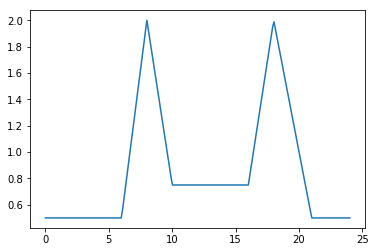

In [3]:
t = np.linspace(0.0, 24.0, num=250)
plt.plot(t, compute_time_of_day_factor(t))

In [4]:
tod = sample_time_of_day(5000)

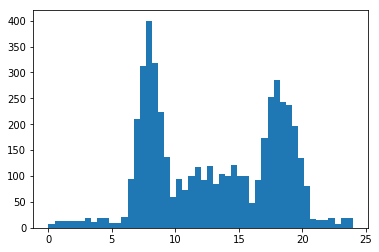

In [5]:
_ = plt.hist(tod, bins=50)

In [6]:
N = 5000

In [7]:
sources = random_uniform_ellipse(N)
targets = random_uniform_ellipse(N)

In [8]:
ct = compute_commute_time(sources, targets, tod)

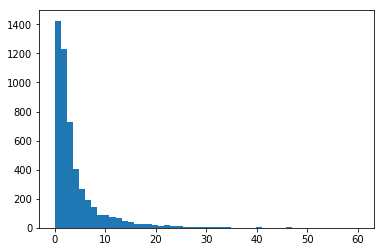

In [9]:
_ = plt.hist(ct, bins=50)

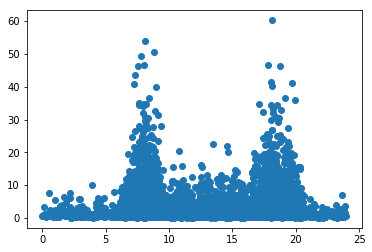

In [10]:
_ = plt.scatter(tod, ct)